In [ ]:
!pip install tensorflow
!pip install contractions
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.4 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
import numpy as np
import pandas as pd
import contractions
import textblob
import re, string, unicodedata

from tqdm import tqdm

#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from typing import Tuple
import copy as cp

import nltk
nltk.download('all')

from sklearn import preprocessing, model_selection,feature_extraction,linear_model, tree, neighbors, ensemble, svm, metrics, pipeline, decomposition


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Suicide_Detection.csv to Suicide_Detection.csv


In [ ]:
data_file="Suicide_Detection.csv"
Suicide_data= pd.read_csv(data_file)

In [ ]:
Suicide_data.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
Suicide_data.tail(5)

,Unnamed: 0,text,class
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,non-suicide


In [ ]:
Suicide_data.shape

(232074, 3)

In [ ]:
Suicide_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [ ]:
Suicide_data_raw= Suicide_data[['class', 'text']]
Suicide_data_raw.sample(5, random_state= 2)

,class,text
115313,suicide,You.‍‍‍‍I feel I deserve nothing. How many liv...
78611,suicide,Laters whoever knows me via this accountI’m cu...
199074,suicide,"Telling my best friend..I need help, how do i ..."
112519,non-suicide,unpopular opinion. Murder is wrong. Murderers ...
160158,suicide,Going to hang myself sitting downI have a rope...


<Axes: title={'center': 'Distribution of Sucidal vs Non Suicidal Posts'}, ylabel='class'>

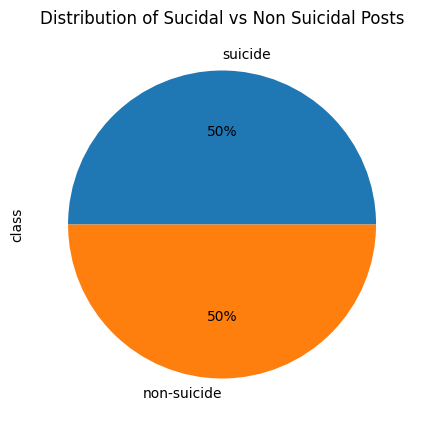

In [ ]:
Suicide_data_raw['class'].value_counts().plot(kind= 'pie', title='Distribution of Sucidal vs Non Suicidal Posts',figsize=(10,5),autopct='%1.0f%%')

In [ ]:

# Defining Functions to clean the text
def clean_contractions(text):
    """Replace contractions in string of text"""
    text = contractions.fix(text)
    return text

def remove_html_tags_func(text):
     return BeautifulSoup(text, 'html.parser').get_text()
    
def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

#def spell_correct(text):
    #text = spelling(text)
    #return text
# create an instance of the Spelling class


def remove_irr_char_func(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)

def remove_extra_whitespaces_func(text):
     return re.sub(r'^\s*|\s\s*', ' ', text).strip()

def remove_duplicates(text):
    words = text.split(" ")
    result = []
    for word in words:
        if word not in result:
            result.append(word)
    return " ".join(result)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [ ]:
#Applying the cleaning functions to the dataset
Suicide_data_raw['clean_text'] = Suicide_data_raw['text'].str.lower()
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(clean_contractions)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_html_tags_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_url_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_accented_chars_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_punctuation_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(reduce_lengthening)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_irr_char_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_extra_whitespaces_func)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_duplicates)
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(remove_emoji)

In [ ]:
stop_words = stopwords.words('english')
Suicide_data_raw['clean_text'] = Suicide_data_raw['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [ ]:
#Selecting the class and the clean text columns
Suicide_data_clean= Suicide_data_raw[['class', 'clean_text']]
Suicide_data_clean.tail(10)

,class,clean_text
232064,non-suicide,ba ad comes naturally song makes feel like lsd
232065,non-suicide,know one cares anyways fighting sans undertale...
232066,suicide,mom tried kill today feel lost second time hap...
232067,suicide,fucking scummy person cannot change itever sin...
232068,non-suicide,something today went sledding friends may seem...
232069,non-suicide,like rock going get anything go
232070,non-suicide,tell many friends lonely everything deprived p...
232071,non-suicide,pee probably tastes like salty tea someone dra...
232072,suicide,usual stuff find herei posting sympathy pity k...
232073,non-suicide,still beaten first boss hollow knight fought t...


In [ ]:
Suicide_data_clean.head(10)

,class,clean_text
0,suicide,ex wife threatening suiciderecently left good ...
1,non-suicide,weird get affected compliments coming someone ...
2,non-suicide,finally almost never hear bad year ever swear ...
3,suicide,need helpjust help crying hard
4,suicide,losthello name adam struggling years afraid pa...
5,suicide,honetly idki know even feel like nothing nowhe...
6,suicide,trigger warning excuse self inflicted burns kn...
7,suicide,ends tonight cannot anymore quit
8,non-suicide,everyone wants edgy making self conscious feel...
9,suicide,life years oldhello year old balding male hair...


In [ ]:
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7), title = None):
    """Find how frequent words are in the text and plot the frequency.
    
    Arguments:
        corpus (str.): text to evaluate word frequency on
        ngrams (list): number of n-grams to look for in corpus
        top (int.)   : number of top words to plot
        figsize (tuple): figure size
        title (str.)   : figure title
    Returns: 
        dtf_freq (DataFrame): dataframe containing frequency of words in each corpus
        """
    
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel= "Word frequency")
    plt.suptitle(title)
    plt.title(f"Top {top} words per n-grams")
    plt.show()
    ax.grid(axis="x")
    return dtf_freq

# suicide:


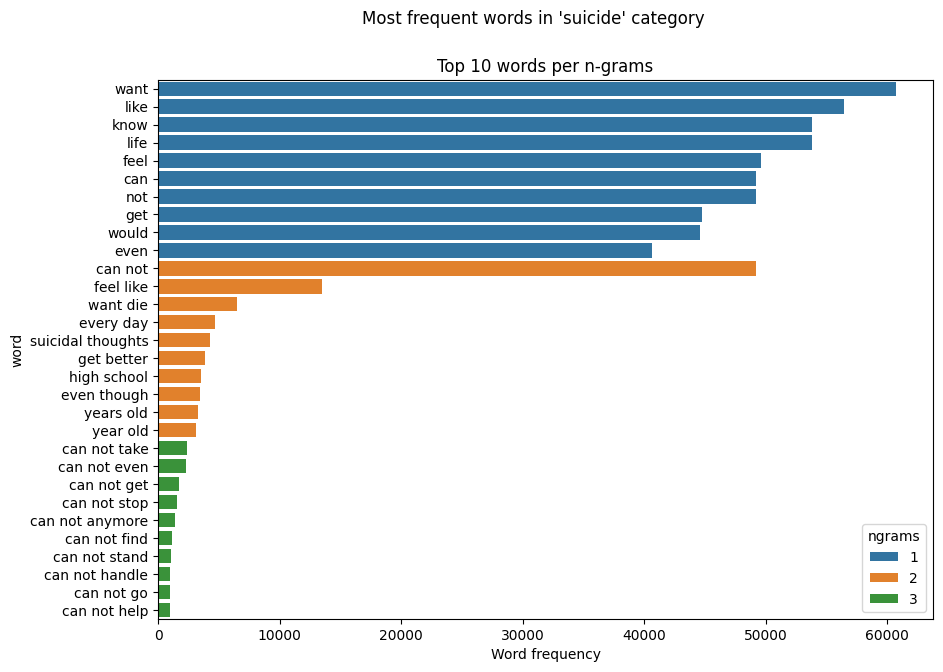

# non-suicide:


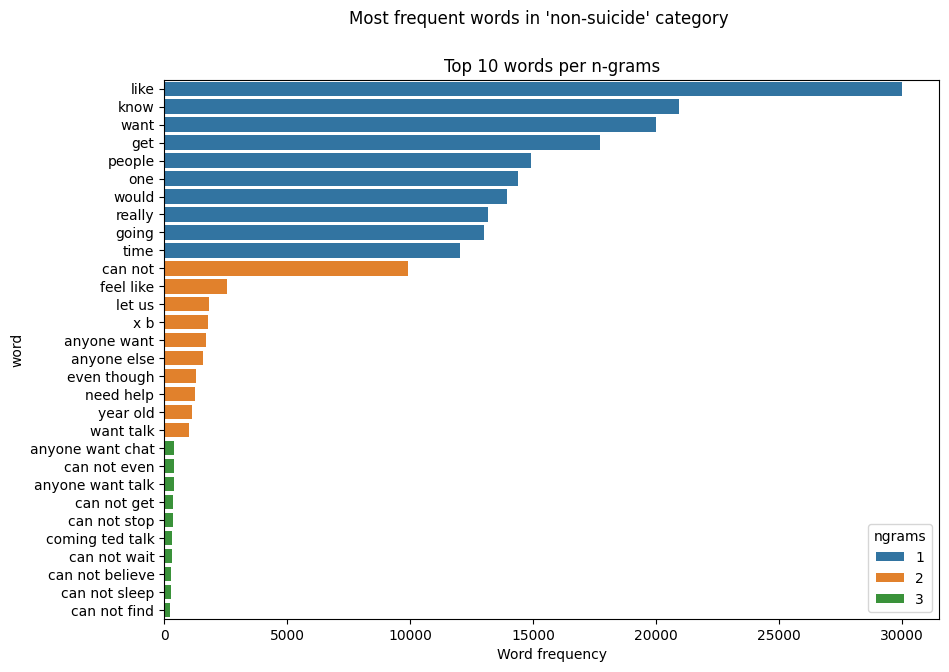

In [ ]:
import seaborn as sns
dtf_freq = pd.DataFrame()
for y in Suicide_data_clean["class"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=Suicide_data_clean[Suicide_data_clean["class"]==y]["clean_text"], ngrams=[1,2,3], top=10, figsize=(10,7), title = f"Most frequent words in '{y}' category")
    dtf_y["class"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [ ]:
import wordcloud

In [ ]:
def plot_wordcloud(corpus, max_words=150, max_font_size=35, figsize=(10,10)):
    """Plot word cloud for a corpus.
    
    Arguments: 
        corpus (str.)       : text to plot word cloud for
        max_words (int.)    : exlude words as freqent as this
        max_font_size (int.): the font size for the most frequent word
        figsize             : figure size
    Returns: 
        plot (matplotlib): wordcloud plot
    """
    wc = wordcloud.WordCloud(background_color='white', colormap= 'magma', max_words=max_words, max_font_size=max_font_size)
    wc = wc.generate(str(corpus)) #if type(corpus) is not dict else wc.generate_from_frequencies(corpus)     
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()


# suicide:


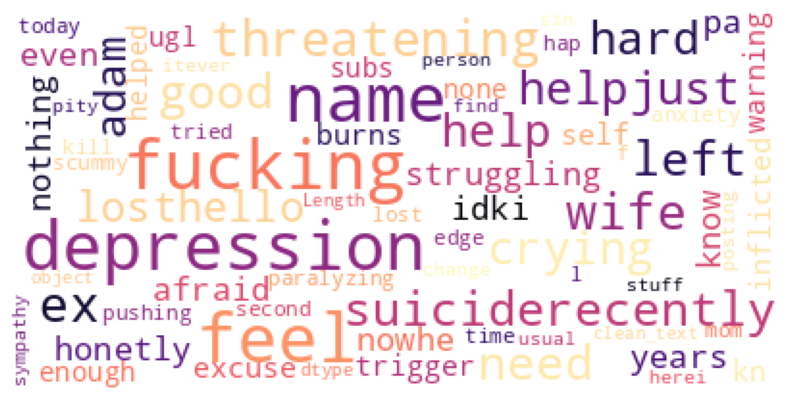

# non-suicide:


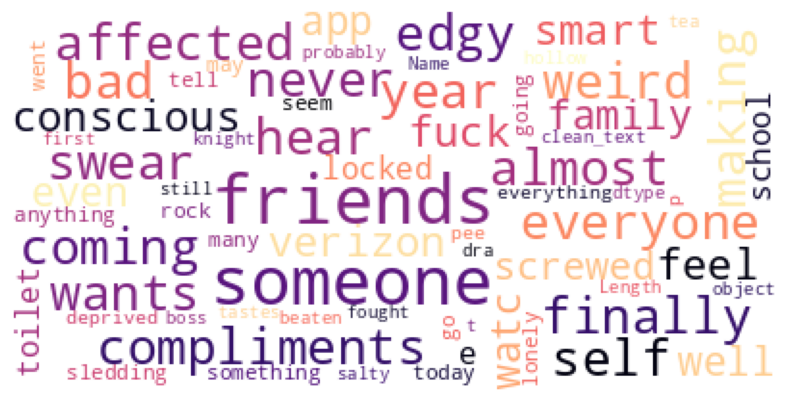

In [ ]:
for y in Suicide_data["class"].unique():
    print(f"# {y}:")
    plot_wordcloud(corpus=Suicide_data_clean[Suicide_data_clean["class"]==y]["clean_text"], max_words=150, max_font_size=35, figsize=(10,5))

In [ ]:
#Creating a word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='White', width=1600,                            
                      height=800,colormap= 'magma', max_words=300).generate(Suicide_data_clean['clean_text'].to_string()) #convert to string using .join

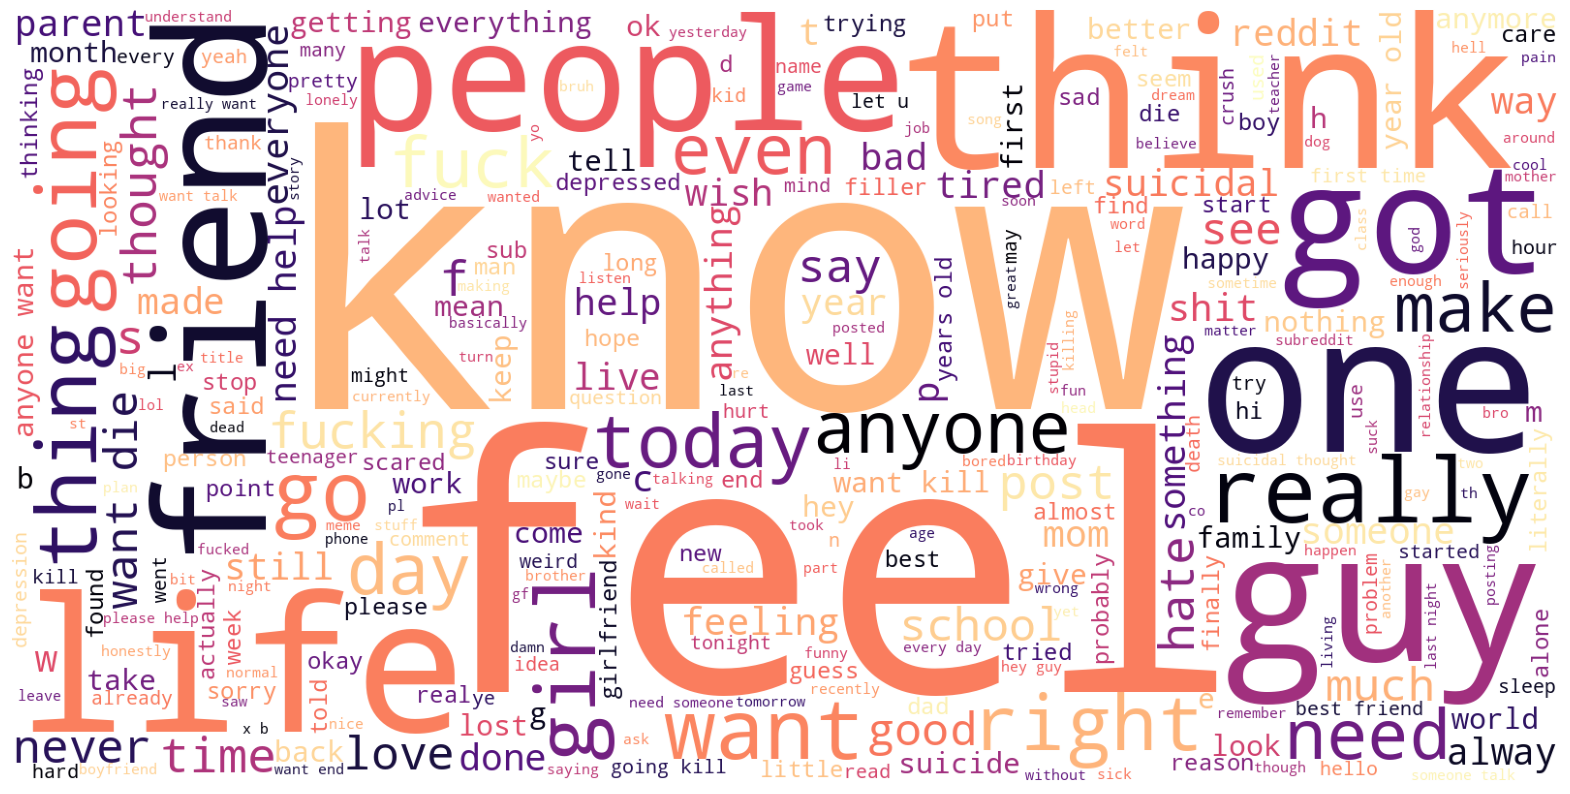

In [ ]:
#Word  cloud for both suicide and non-sucicde
fig, ax = plt.subplots(figsize=(20,20))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
#plt.savefig("Suicidecloud.png2", format="png")
plt.imshow(wordcloud)  

In [ ]:
Suicide_data_clean.head(10)

,class,clean_text
0,suicide,ex wife threatening suiciderecently left good ...
1,non-suicide,weird get affected compliments coming someone ...
2,non-suicide,finally almost never hear bad year ever swear ...
3,suicide,need helpjust help crying hard
4,suicide,losthello name adam struggling years afraid pa...
5,suicide,honetly idki know even feel like nothing nowhe...
6,suicide,trigger warning excuse self inflicted burns kn...
7,suicide,ends tonight cannot anymore quit
8,non-suicide,everyone wants edgy making self conscious feel...
9,suicide,life years oldhello year old balding male hair...


In [ ]:
#Encoding the class using a mapping function
Suicide_data_clean['class'] = Suicide_data_clean['class'].map({'suicide': 1, 'non-suicide':0})

In [ ]:
Suicide_data_clean.tail()

,class,clean_text
232069,0,like rock going get anything go
232070,0,tell many friends lonely everything deprived p...
232071,0,pee probably tastes like salty tea someone dra...
232072,1,usual stuff find herei posting sympathy pity k...
232073,0,still beaten first boss hollow knight fought t...


In [ ]:
#Splitting data : Define X and Y
X = np.array(Suicide_data_clean['clean_text'])
y = np.array(Suicide_data_clean['class'])

#converting text into vectors
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
X=cv.fit_transform(X)

# split data in train, split sets (leave out 30% of the data for validation)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 12)
     

## **Machine** **Learning**

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf= DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
#Defining the ypred
y_pred=clf.predict(X_test)

In [ ]:
#Printing a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85     34717
           1       0.85      0.86      0.85     34906

    accuracy                           0.85     69623
   macro avg       0.85      0.85      0.85     69623
weighted avg       0.85      0.85      0.85     69623



In [ ]:
#using a sample text to try the accuracy of the model
test_data='i literally died out of joy '
df=cv.transform([test_data]).toarray()
print(clf.predict(df))

[0]


In [ ]:
test_data1='Good bye, This is the last message i will write '
df=cv.transform([test_data1]).toarray()
print(clf.predict(df))

[0]


In [ ]:
#Logistic Regression
logreg = linear_model.LogisticRegression(random_state=12)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     34717
           1       0.95      0.91      0.93     34906

    accuracy                           0.93     69623
   macro avg       0.93      0.93      0.93     69623
weighted avg       0.93      0.93      0.93     69623



In [ ]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
test_data='i am so happy that i could kill myself now'
df=cv.transform([test_data]).toarray()
print(logreg.predict(df))

[1]


In [ ]:
test_data1='Good bye, This is the last message i will write '
df=cv.transform([test_data1]).toarray()
print(logreg.predict(df))

[1]


In [ ]:

test_data2='i literally died out of joy '
df=cv.transform([test_data2]).toarray()
print(logreg.predict(df))

[0]


In [ ]:
#Random Forest
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train,y_train)
y_pred=rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     34717
           1       0.88      0.92      0.90     34906

    accuracy                           0.90     69623
   macro avg       0.90      0.90      0.90     69623
weighted avg       0.90      0.90      0.90     69623



In [ ]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
test_data='fuck you all!! i am going to kill you'
df=cv.transform([test_data]).toarray()
print(rf_clf.predict(df))

[1]


In [ ]:
#KNN
knn_clf = neighbors.KNeighborsClassifier() 
knn_clf.fit(X_train,y_train)
y_pred=knn_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78     34717
           1       0.86      0.58      0.69     34906

    accuracy                           0.74     69623
   macro avg       0.77      0.74      0.74     69623
weighted avg       0.77      0.74      0.74     69623



In [ ]:
knn_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
test_data='The sun is shining so bright today and it seems as if there is an iota of hope for some people, but all i see is a perfect day to kill myself'
df=cv.transform([test_data]).toarray()
print(knn_clf.predict(df))

[1]


## Models Accuracy

Logistics Regression - 93%

Decision Tree - 85%

KNN - 74%

Random Forest - 90%